<a href="https://colab.research.google.com/github/Tyred/TimeSeries_OCC-PUL/blob/main/Notebooks/OC_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [65]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, accuracy_score, recall_score

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

## Reading the dataset from Google Drive


In [66]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')

tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", delimiter="\t",)

labels      = te_data[:, 0]                             # labels
print("Labels:", np.unique(labels))

Dataset: Wafer
Labels: [-1.  1.]


## Splitting in Train-Test data

In [67]:
class_label = int(input('Positive class label: '))

train_data  = tr_data[tr_data[:, 0] == class_label, 1:] # train
test_data   = te_data[:, 1:]                            # test

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Positive class label: -1
Train data shape: (97, 152)
Test data shape: (6164, 152)


## Labeling for OCC Task
<li> Label 1 for positive class </li>
<li> Label -1 for other class(es) </li>

In [68]:
occ_labels = [1 if x == class_label else -1 for x in labels]
print("Positive samples:", occ_labels.count(1))
print("Negative samples:", occ_labels.count(-1))

Positive samples: 665
Negative samples: 5499


# MDS Plot 

In [69]:
embedding = MDS(n_components=2, random_state=42)
mds_data = embedding.fit_transform(train_data)
mds_test = embedding.fit_transform(test_data)
print(mds_data.shape)
print(mds_test.shape)

(97, 2)
(6164, 2)


## Train

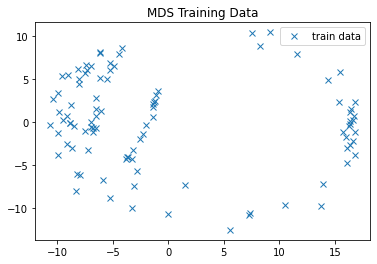

In [70]:
x = [row[0] for row in mds_data]
y = [row[1] for row in mds_data]

plt.plot(x, y, 'x',label='train data')
plt.title('MDS Training Data')
plt.legend()
plt.show()

## Test

In [71]:
negative_mds_test = np.array([x for x in mds_test[np.where(labels!=class_label)]])
positive_mds_test = np.array([x for x in mds_test[np.where(labels==class_label)]])

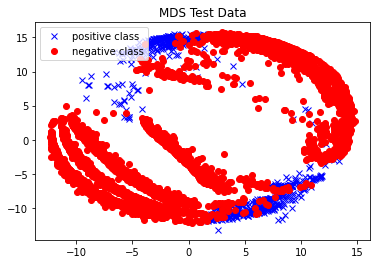

In [72]:
x_positive = [row[0] for row in positive_mds_test]
y_positive = [row[1] for row in positive_mds_test]

x_negative = [row[0] for row in negative_mds_test]
y_negative = [row[1] for row in negative_mds_test]

plt.plot(x_positive, y_positive, 'x', label='positive class', c = 'blue')
plt.plot(x_negative, y_negative, 'o', label='negative class', c = 'red')
plt.title('MDS Test Data')
plt.legend()
plt.show()

# Feature extraction


## PCA

In [73]:
"""pca = PCA(svd_solver='full')

train_data = pca.fit_transform(train_data)
test_data = pca.transform(test_data)
print(train_data.shape)"""

"pca = PCA(svd_solver='full')\n\ntrain_data = pca.fit_transform(train_data)\ntest_data = pca.transform(test_data)\nprint(train_data.shape)"

## Convolutional Autoencoder


In [74]:
# Convolutional Autoencoder with MaxPooling:
class ConvAutoencoder(tf.keras.Model):
    def __init__(self, serie_length):
        super(ConvAutoencoder, self).__init__()
        self.conv_1 = keras.layers.Conv1D(128, 3, activation='swish', padding='same', input_shape=(serie_length))
        self.max_1 = keras.layers.MaxPooling1D(2, padding='same')
        self.conv_2 = keras.layers.Conv1D(64, 3, activation='swish', padding='same')
        self.max_2 = keras.layers.MaxPooling1D(2, padding='same')
        self.conv_3 = keras.layers.Conv1D(1, 3, activation='swish', padding='same')
    
        # encoded representation
        self.encoded = keras.layers.MaxPooling1D(2, padding='same')
        
        # decoder layers
        self.conv_4 = keras.layers.Conv1D(1, 3, activation='swish', padding='same')
        self.up_1 = keras.layers.UpSampling1D(2)
        self.conv_5 = keras.layers.Conv1D(64, 3, activation='swish', padding='same')
        self.up_2 = keras.layers.UpSampling1D(2)
        self.conv_6 = keras.layers.Conv1D(128, 3, activation='swish', padding='same')
        self.up_3 = keras.layers.UpSampling1D(2)
        self.decoded = keras.layers.Conv1D(1, 3, activation='linear', padding='same')
        
    def call(self, inputs):
        padding = inputs.shape[1] % 8
        x = self.encode(inputs)
        x = self.conv_4(x)
        x = self.up_1(x)
        x = self.conv_5(x)
        x = self.up_2(x)
        x = self.conv_6(x)
        x = self.up_3(x)
        if padding != 0:
            x = keras.layers.Cropping1D(cropping=(padding, 0))(x)
        return self.decoded(x)
    
    def encode(self, inputs):
        padding = inputs.shape[1] % 8
        if padding != 0:
            inputs = keras.layers.ZeroPadding1D(padding=(padding, 0))(inputs)
        x = self.conv_1(inputs)
        x = self.max_1(x)
        x = self.conv_2(x)
        x = self.max_2(x)
        x = self.conv_3(x)
        return self.encoded(x)
        
    
    def model(self):
        x = keras.layers.Input(shape=(serie_length, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

### Initializing and training the Conv Autoencoder

In [75]:
serie_length = train_data.shape[1]
model = ConvAutoencoder((serie_length, 1))

model.compile(optimizer='adam', loss='mse')

# Train
batch_size = 16
epochs = 50

train_data.shape = train_data.shape[0], train_data.shape[1], 1
model.fit(train_data, train_data, epochs=epochs, batch_size=batch_size)

Epoch 1/50
7/7 [==============================] - 2s 77ms/step - loss: 0.9842
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 0.8648
Epoch 3/50
7/7 [==============================] - 0s 7ms/step - loss: 0.6516
Epoch 4/50
7/7 [==============================] - 0s 7ms/step - loss: 0.5450
Epoch 5/50
7/7 [==============================] - 0s 7ms/step - loss: 0.4470
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.3716
Epoch 7/50
7/7 [==============================] - 0s 8ms/step - loss: 0.3265
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.2961
Epoch 9/50
7/7 [==============================] - 0s 8ms/step - loss: 0.2771
Epoch 10/50
7/7 [==============================] - 0s 10ms/step - loss: 0.2618
Epoch 11/50
7/7 [==============================] - 0s 8ms/step - loss: 0.2497
Epoch 12/50
7/7 [==============================] - 0s 8ms/step - loss: 0.2430
Epoch 13/50
7/7 [==============================] - 0s 7ms/step - loss: 

# OC-SVM Fitting 

In [82]:
train_data_encoded = np.array(model.encode(train_data))
train_data_encoded.shape = train_data_encoded.shape[0], train_data_encoded.shape[1]
clf = OneClassSVM(gamma='scale', nu=0.15, kernel='rbf').fit(train_data_encoded)

# Testing and Evaluating Results

In [83]:
test_data.shape = test_data.shape[0], test_data.shape[1], 1

test_data_encoded = np.array(model.encode(test_data))
test_data_encoded.shape = test_data_encoded.shape[0], test_data_encoded.shape[1]
result_labels = clf.predict(test_data_encoded)

acc = accuracy_score(occ_labels, result_labels)
precision = precision_score(occ_labels, result_labels)
recall = recall_score(occ_labels, result_labels)

print("Accuracy: %.2f"  % (acc*100) + "%")
print("Precision: %.2f" % (precision*100) + "%")
print("Recall: %.2f"    % (recall*100) + "%")

Accuracy: 96.46%
Precision: 87.95%
Recall: 77.89%
